In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
import DualwormFunctions as dw
import Observables as obs

%load_ext line_profiler
%load_ext memory_profiler

import RunBasis
import argparse
import StartStates as strst
import numpy as np

import AnalysisFunctions as af # functions to make the analysis code cleaner
import KagomeDrawing as kdraw


import matplotlib.pyplot as plt
%matplotlib inline

import yep

In [3]:
nst = 128;
nsm = 16;
nips = 4;
nrps = 4;
nb = 4;
measperiod = 1;
nt = 64
nh = 1
ncores = 4
nmaxiter = 1
L = 8
J1 = -0.2
J2 = 1
J3 = 1
h = 0
notfullstateupdate = False
stroutput = "Phase8_J1{0}J2{1}J3{2}_L{3}_tests_2".format(J1,J2,J3,L)

In [4]:
def genArgs():
    parser = argparse.ArgumentParser()
    
    parser.add_argument('-f', type = str)

    parser.add_argument('--L', type = int, default = L, help = 'Lattice side size')

    # COUPLINGS
    parser.add_argument('--J1', type = float, default = J1,
                        help = 'NN coupling') # nearest-neighbour coupling
    parser.add_argument('--J2', type = float, default = J2,
                        help = '2nd NN coupling') # 2nd NN coupling
    parser.add_argument('--J3', type = float, default = J3,
                        help = '3rd NN coupling') # 3rd NN coupling
    parser.add_argument('--J4', type = float, default = 0.0,
                        help = '4th NN coupling') 
    #NUMBER OF STEPS AND ITERATIONS
    parser.add_argument('--nst', type = int, default = nst,
                        help = 'number of thermalisation steps') # number of thermalisation steps
    parser.add_argument('--nsm', type = int, default = nsm,
                        help = 'number of measurements steps') # number of measurement steps
    parser.add_argument('--nips', type = int, default = nips,
                        help = 'number of worm constructions per MC step')
    parser.add_argument('--nrps', type = int, default = nrps,
                        help = 'number of replica loops per MC step')
    parser.add_argument('--measperiod', type = int, default = measperiod,
                        help = 'number of nips worm building + swaps between measurements')
    parser.add_argument('--nb', type = int, default = nb,
                        help = 'number of bins')

    #PARALLELISATION
    parser.add_argument('--ncores', type = int, default = ncores,
                        help = 'number of threads to use')

    
    # INITIALISATION PARAMETERS
    parser.add_argument('--randominit', default = True, action ='store_true',
                        help = 'intialise the states randomly')
    parser.add_argument('--same', default = False, action = 'store_true',
                        help = '''initialise all temperatures with the same
                        state (debug purposes)''')
    parser.add_argument('--testinit', default = True, action = 'store_true',
                        help = '''test some given initialisation''')
    parser.add_argument('--magninit', default = False, action = 'store_true',
                        help = '''initialise all the temperature with
                        one of the m=1/3 GS''')
    parser.add_argument('--magnstripes', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       m=1/3 stripes''')
    parser.add_argument('--maxflip', default = False, action = 'store_true',
                       help = '''initialise all the temperature with
                       maximally flippable plateau''')
    parser.add_argument('--loadfromfile', default = False, action = 'store_true',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    parser.add_argument('--filename', type = str, default = '',
                       help = '''initialise all the states with
                       results from a previously performed simulations''')
    
    #WORM PARAMETERS
    parser.add_argument('--nmaxiter', type = int, default = nmaxiter,
                        help = '''maximal number of segments in a loop update over the
                        size of the lattice (1 = 1times the number of dualbonds in the
                        lattice)''')
    parser.add_argument('--measupdate', default = False, action = 'store_true',
                       help = '''activate to mimic the action of the measuring tip''')
    parser.add_argument('--p', type = float, default = 0.0, 
                       help = '''prob of the measuring tip flipping the spin (number between 0 and 1)''')
    parser.add_argument('--ssf', default = True, action = 'store_true',
                        help = 'activate for single spin flip update')
    parser.add_argument('--notfullssfupdate', default = notfullstateupdate, action = 'store_true',
                        help = 'whether to fully update the state or not at each ssf step *during the measurement phase*')
    parser.add_argument('--alternate', default = True, action = 'store_true',
                        help = 'activate for single spin flip update and dw update')
    parser.add_argument('--checkgs', default = True, action = 'store_true',
                        help = 'activate to debug ssf')
    
    #TEMPERATURE PARAMETERS
    parser.add_argument('--t_list', nargs = '+', type = float, default = [0.001,60],
                        help = 'list of limiting temperature values')
    parser.add_argument('--nt_list', nargs = '+', type = int, default = [nt],
                        help = 'list of number of temperatures in between the given limiting temperatures')
    parser.add_argument('--log_tlist', default = True, action='store_true',
                        help = 'state whether you want the temperature be spaced log-like or linear-like (activate if you want log)')
    parser.add_argument('--stat_temps_lims', nargs = '+', type = float,
                        help = '''limiting temperatures for the various ranges of
                        measurements''') 
                        #default will be set to none, and then we can decide what to do later on.
    #MAGNETIC FIELD PARAMETERS
    parser.add_argument('--h_list', nargs = '+', default = [0,h],type = float,
                        help = 'list of limiting magnetic field values')
    parser.add_argument('--nh_list', nargs = '+', default = [nh], type = int,
                        help = 'list of number of magnetic fields in between the given limiting temperatures')
    parser.add_argument('--stat_hfields_lims', nargs = '+', type = float,
                help = '''limiting magnetic fields for the various ranges of
                measurements''') 
    #MEASUREMENTS PARAMETERS
    parser.add_argument('--generatingMode', default = True, action = 'store_true',
                        help = 'activate if you want to generate a number of ground states and low energy states')
    parser.add_argument('--energy', default = True, action = 'store_true',
                        help = 'activate if you want to save the energy')
    parser.add_argument('--magnetisation', default = False, action = 'store_true',
                        help = 'activate if you want to save the magnetisation')
    parser.add_argument('--charges', default = False, action = 'store_true',
                        help = 'activate if you want to save the charges')
    parser.add_argument('--frustratedT', default = False, action = 'store_true',
                        help = 'activate if you want to save the frustrated triangles')
    parser.add_argument('--correlations', default = True, action = 'store_true',
                        help = 'activate if you want to save either central or all correlations')
    parser.add_argument('--both', default = False, action = 'store_true',
                        help = '''both central and first correlations''')
    parser.add_argument('--firstcorrelations', default = True, action = 'store_true',
                        help = 'activate if you want to save first correlations, otherwise will save central')
    parser.add_argument('--sref0', nargs = '+', type = int, default = [L-1, L-1, 0], help = 'ref spin 0')
    parser.add_argument('--sref1', nargs = '+', type = int, default = [L-1, L-1, 1], help = 'ref spin 1')
    parser.add_argument('--sref2', nargs = '+', type = int, default = [L-1, L-1, 2], help = 'ref spin 2')
    #SAVE
    parser.add_argument('--output', type = str, default = stroutput, help = 'saving filename (.pkl will be added)')
    parser.add_argument('--verbose', default = False, action = 'store_true', help = 'verbose')
    args = parser.parse_args()
    
    return args

In [5]:
def callRunBasis():
    args = genArgs()
    return RunBasis.main(args)

In [6]:
#%%prun -s  -T prun0
#yep.start(stroutput+'.log')
%lprun -f dw.mcs_swaps callRunBasis()
#yep.stop()

-------------------Initialisation--------------------
./Phase8_J1-0.2J21J31_L8_tests_2_folder/backup.hkl
Lattice side size:  8
J1  -0.2
J2  1
J3  1
J3st  1
Couplings extracted
Hamiltonian expression (without field) computed
single spin flip update
alternating ssf and dw update
Number of temperatures:  64
Temperatures: [1.00000000e-03 1.19081328e-03 1.41803628e-03 1.68861644e-03
 2.01082688e-03 2.39451936e-03 2.85142547e-03 3.39551532e-03
 4.04342475e-03 4.81496390e-03 5.73372298e-03 6.82779349e-03
 8.13062718e-03 9.68205886e-03 1.15295243e-02 1.37295107e-02
 1.63492837e-02 1.94689442e-02 2.31838774e-02 2.76076692e-02
 3.28755792e-02 3.91486764e-02 4.66187639e-02 5.55142433e-02
 6.61070984e-02 7.87212109e-02 9.37422637e-02 1.11629533e-01
 1.32929931e-01 1.58294727e-01 1.88499464e-01 2.24467666e-01
 2.67299078e-01 3.18303293e-01 3.79039789e-01 4.51365616e-01
 5.37492171e-01 6.40052818e-01 7.62183397e-01 9.07618114e-01
 1.08080371e+00 1.28703541e+00 1.53261886e+00 1.82506290e+00
 2.173309

In [7]:
# Create a folder to save the pictures
foldername = "./" + stroutput + "_folder/" 
results_foldername = 'Results/'
os.makedirs(foldername +results_foldername, exist_ok = True)

filenamelist = ["backup"]
n = len(filenamelist)

In [8]:
[L, numsites, J1, J2, J3, J3st, J4, nb, num_in_bin, 
 htip, Ttip, pswitch, uponly, path,
 temperatures, nt,
 stat_temps, temperatures_plots, hfields, nh, 
 stat_hfields, hfields_plots, listfunctions, sref, ids2walker] = \
af.LoadParameters(foldername, filenamelist)

In [9]:
kw = {'binning': False, 'plzplot': True, 'plotmin': 0, 'plotmax': 16}
[t_h_MeanE, t_h_MeanEsq, t_h_varMeanE, t_h_varMeanEsq, C, ErrC] = \
 af.LoadEnergy(foldername, filenamelist, numsites,
               nb, stat_temps, temperatures, stat_hfields,
               listfunctions, **kw)


[-1.8]


In [10]:
print(t_h_MeanE[0][0])
print((2/3 * J1[0] - (2/3) * J2[0] - J3[0]))

[-1.8]
-1.7999999999999998


In [11]:
s_ijl, ijl_s = kdraw.createspinsitetable(L[0])
print("nb ", nb, "num_in_bin ", num_in_bin)
swapst_th, swapsh_th, swapst, swapsh = af.LoadSwaps(foldername, filenamelist, nb, num_in_bin, nh, nt)

n = len(L)
failedth, failedssfth, failed, failedssf = \
af.LoadUpdates(foldername, filenamelist, nb, num_in_bin, [9*L[i]**2 for i in range(n)])


nb  [4] num_in_bin  [4]


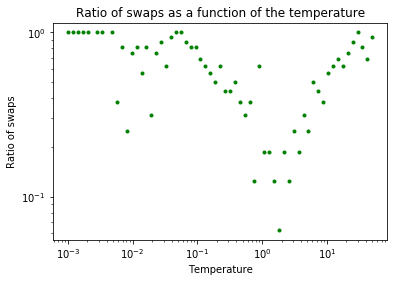

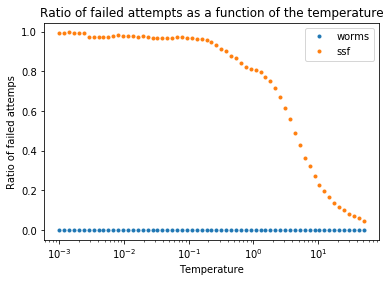

In [12]:
tidmin = 0
tidmax = nt
af.SwapsAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername, swapst, swapsh)
af.FailedAnalysis(L, n, tidmin, tidmax, temperatures, hfields,
                 foldername, results_foldername,failed, failedssf)